# Shared Memory Programming

We wants to handle shared memory between process.
We will have different kind of access:

* _Read Only_ memory access to the shared data.
* _Read and Write_ In this case, we can call the global variable from our distributed code and modify it inside

In [1]:
%matplotlib inline
import multiprocessing as mp
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time
from multiprocessing.sharedctypes import Value, Array, RawArray
from multiprocessing import Process, Lock
import ctypes

In [2]:
import importlib

# Shared Memory
Python pass the parameters by value. That means, they passes not the memory position where the variable is stored, but also they pass the value of the parameter variable.

That is why if we change the value in the invoked function, the changes will not be reflected out of the function.

But the objects and structures it passes the value of the memory possition where the oject/structure is stored. That is why the NumPy arrays will reflect the changes inside them.

We can play with this condition, but at the same time, we need to take care about how we handle the data.

# Race Condition
The *Race Condition* happens when two or more processes can access shared memory, trying to read and write in the same memory position, without control.

This first parallel Multiple Instructions, Multiple Data parallel program will try to make deposits and withdraws over a shared memory value, called balance. 
It will start with a value of 100.

The use of Pool execution is oriented to Single Instruction, Multiple Data parallel processes: We define just one execution function, which will be applied to multiple data.

Now, if we will execute a Multiple Instruction, Multiple Data program, we need to use the *multiprocessing.Process* class.

In this case, we construct as many of multiprocessing.Process objects we need, assigning which function will be executed in each one of the parallel processes, and passing the values of their arguments.

After defining the Process objects, we start those processes with the method start() and each one of them will start to run.

To synchronize the execution, we can wait until one parallel process ends using the method join().

In [3]:
import freerunning as fr

The method _withdraw_ is:
<code>
def withdraw(balance):
    for _ in range(10000):
        balance.value = balance.value - 1
</code>

and the method _deposit_ is:
<code>
def deposit(balance):
    for _ in range(10000):
        balance.value = balance.value + 1
</code>

In [4]:
def perform_transactions(): 
  
    # initial balance (in shared memory) 
    balance = mp.Value('i', 100) 
  
    # creating new processes 
    p1 = mp.Process(target=fr.withdraw, args=(balance,)) 
    p2 = mp.Process(target=fr.deposit, args=(balance,)) 
  
    # starting processes 
    p1.start() 
    p2.start() 
  
    # wait until processes are finished 
    p1.join() 
    p2.join() 
  
    # print final balance 
    print("Final balance = {}".format(balance.value)) 

We will run 10 times the main function "perform_transactions".
Check 2 things: final value and time used

In [5]:
start_time=time.time()
for _ in range(10): 
    # perform same transaction process 10 times 
    perform_transactions()
print("--- %s seconds ---" % (time.time() - start_time))

Final balance = -770
Final balance = 1165
Final balance = 946
Final balance = -2327
Final balance = -586
Final balance = 3121
Final balance = 895
Final balance = -2282
Final balance = 1310
Final balance = -1710
--- 3.6337459087371826 seconds ---


Here, the final balance are not correct!! Why?<br>
We have two different parallel processes reading and writing the same shared variables.
. In this case, we says: we have a race condition

We do not controls the state of the shared variable *balance*. We need how the execution is realized.

In any case, check the execution time.

# Shared Memory with locks and sempahores

If we need to handle a concurrent access to read/write memory positions, we will need to improve our program (a lot)...

* We will need to define a process and resources manager
* We will define the shared memory structures
* We will need to associate the shared memory and resource manager to the pool of processes

We will need several new modules and objects to handle shared memory information:
* From multiprocessing module we will import Process and Lock objects. We will use Lock objects to set locks in our shared memory objects
* From multiprocessing.sharedctypes we import shared memory objects like 
    * Value: a single shared memory value object, like integers, float, etc
    * Array: an object to handle shared memory arrays, like matrixes, with locks. Multiprocess safe shared memory object
    * RawArray: It is like an Array, but without locks. This kind of objects are Unsafe (but fast access)
* Import ctypes for data type definition in shared structures. The different values for c_types are available in: https://docs.python.org/3/library/ctypes.html#module-ctypes

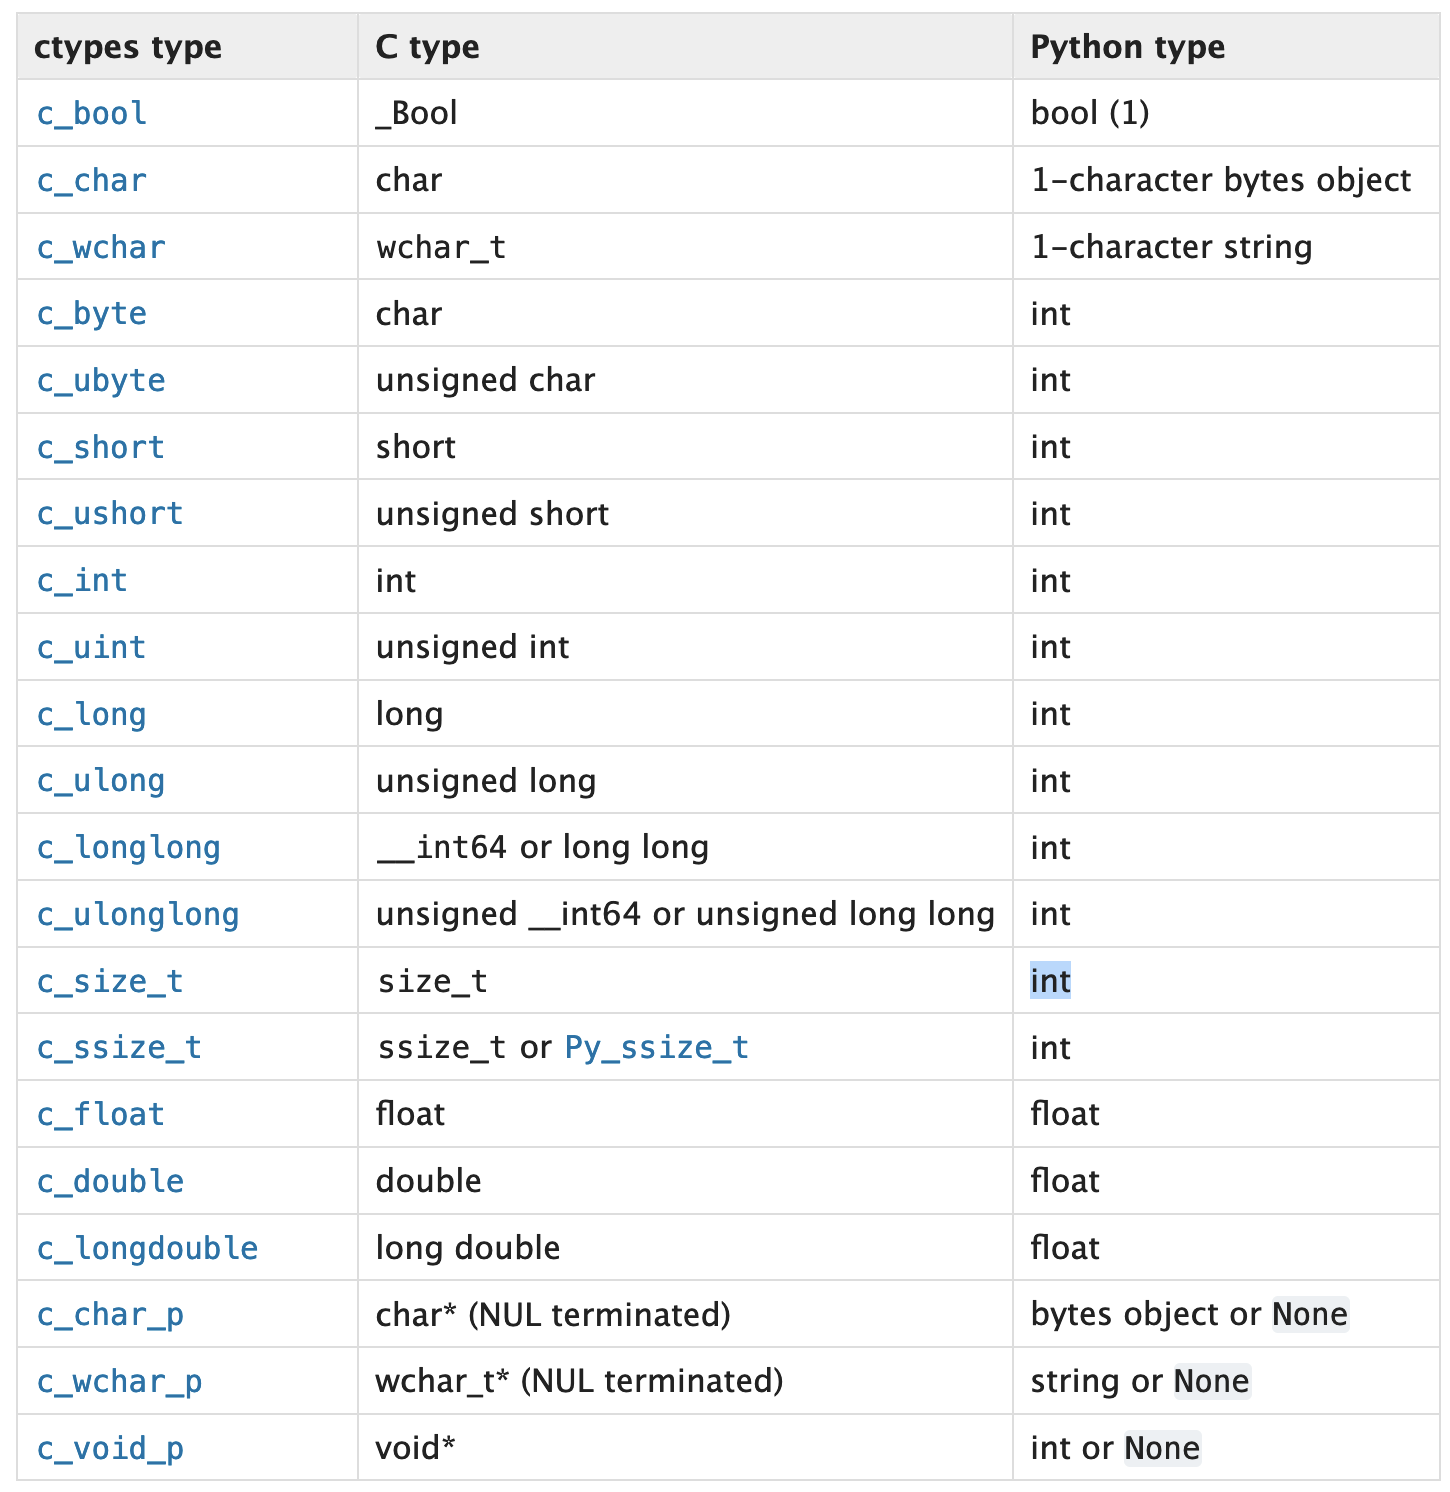

### Modifications in our code

We will invoke a new methods, more complex, but define an access control.

We will use a Value object, called balance, and a global mp.Lock called... lock.

The external lock method allows us block the access to all shared variables inside the blocked block code:

<code>
def withdraw2(balance, lock):
    for _ in range(10000):
        lock.acquire()
        balance.value = balance.value - 1
        lock.release()
</code>
In this case, the shared Value variable balance is blocked to be accessed from other processes for read and write.
So, once blocked, we read the balance.value is read, decrease by one and then released to be accessed by other processes.

In the same way the method deposit2:

<code>
def deposit2(balance, lock):
    for _ in range(10000):
        lock.acquire()
        balance.value = balance.value + 1
        lock.release()
</code>

Using this access control, we avoid race condition.

In [6]:
def perform_transactions2(): 
  
    # initial balance (in shared memory) 
    balance = mp.Value('i', 100) 
  
    # creating a lock object 
    lock = mp.Lock() 
  
    # creating new processes 
    p1 = mp.Process(target=fr.withdraw2, args=(balance,lock)) 
    p2 = mp.Process(target=fr.deposit2, args=(balance,lock)) 
  
    # starting processes 
    p1.start() 
    p2.start() 
  
    # wait until processes are finished 
    p1.join() 
    p2.join() 
  
    # print final balance 
    print("Final balance = {}".format(balance.value)) 

In [7]:
start_time=time.time()
for _ in range(10): 
    # perform same transaction process 10 times 
    perform_transactions2() 
print("--- %s seconds ---" % (time.time() - start_time))

Final balance = 100
Final balance = 100
Final balance = 100
Final balance = 100
Final balance = 100
Final balance = 100
Final balance = 100
Final balance = 100
Final balance = 100
Final balance = 100
--- 3.171600818634033 seconds ---


## Distributed dot product with shared accumulator
In this first example we will implements the distributed dot product, first, without lock access, and then, with lock access.
We will observe the different hazzards if we do not use a lock, but if the lock is misplaced, it will cause a performance degradation.

In [8]:
import importlib
import myfunctions3 as my

In [9]:
importlib.reload(my)

<module 'myfunctions3' from 'C:\\Users\\envel\\Desktop\\UNI-AÑO4\\Primer Cuatri\\Massive Computing\\Session5_2025\\myfunctions3.py'>

In [10]:
NUMCORES=20

In [11]:
NUMDATA=1000000
NUM_CHUNK=64

We generate our data: 2 random vectors of type float, with values between [0,1) and prepare for our dot function

In [12]:
data_X=np.random.random(NUMDATA)
data_Y=np.random.random(NUMDATA)

This is our reference result (the correct one)

In [13]:
print(np.dot(data_X,data_Y))

249593.49080626445


In [14]:
Vdata = list(zip(data_X,data_Y))

In [15]:
print(len(Vdata))

1000000


In [16]:
Vdata[0]

(0.12795367642959643, 0.15327736816171278)

Now, we will split the zip file in NUM_CHUNK vectors (**warning: spoiler alert**)

In [17]:
sDV=np.split(np.array(list(Vdata)),NUM_CHUNK)

This first version ivokes a wrong function. 
Check the exit result.

In [18]:
def distributed_dot_1(sdV,numprocs):
    A=Value('d') #create a shared accumulator A 
    A.value=0    #Initialize to 0
    with mp.Pool(processes=numprocs,initializer=my.dot_init,initargs=[A]) as p:
        accu = p.map(my.shared_dot_1,sdV)
    return A.value

In [19]:
%%time
a=distributed_dot_1(sDV,NUMCORES)

CPU times: total: 93.8 ms
Wall time: 7.87 s


In [20]:
print(a)

29770.339689335236


In [21]:
init_time=time.time()
for c in range(10):
    a=distributed_dot_1(sDV,NUMCORES)
final_time=time.time()
print("Average time over 10 samples: {0}".format((final_time-init_time)/10))

Average time over 10 samples: 8.430181407928467


Run several times and compare the results with the reference result.
Why it is every time different? And where are the errors?

#### Second version:
Now, we will invokes the function shared_dot_2

In [22]:
def distributed_dot_2(sdV,numprocs):
    A=Value('d') #create a shared accumulator A 
    A.value=0    #Initialize to 0
    with mp.Pool(processes=numprocs,initializer=my.dot_init,initargs=[A]) as p:
        accu = p.map(my.shared_dot_2,sdV)
    return A.value

In [23]:
%%time
a=distributed_dot_2(sDV,NUMCORES)

CPU times: total: 78.1 ms
Wall time: 1.76 s


In [24]:
print(a)

249593.49080626847


In [25]:
init_time=time.time()
for c in range(10):
    a=distributed_dot_2(sDV,NUMCORES)
final_time=time.time()
print("Average time over 10 samples: {0}".format((final_time-init_time)/10))

Average time over 10 samples: 1.964127206802368


Now, the returned value is correct, but the function is not optimal. Check in the shared_dot_2 function, and analyze where the lock is defined.

### Third version
Now, we will invokes the function shared_dot 3. Compare times

In [26]:
def distributed_dot_3(sdV,numprocs):
    A=Value('d') #create a shared accumulator A 
    A.value=0    #Initialize to 0
    with mp.Pool(processes=numprocs,initializer=my.dot_init,initargs=[A]) as p:
        accu = p.map(my.shared_dot_3,sdV)
    return A.value

In [27]:
%%time
a=distributed_dot_3(sDV,NUMCORES)

CPU times: total: 15.6 ms
Wall time: 986 ms


In [28]:
print(a)

249593.49080626445


In [29]:
init_time=time.time()
for c in range(10):
    a=distributed_dot_3(sDV,NUMCORES)
final_time=time.time()
print("Average time over 10 samples: {0}".format((final_time-init_time)/10))

Average time over 10 samples: 1.2462124824523926


Ok, now, the average time taken by the third code is less than one half of the second version.<br/>
Analize where the get_lock() is placed, and look for an explanation.

## Second Section:

Image filtering: When we filter an image, we apply a mask over each position in an image. For example:
A smooth filter calculate the value in a pixel (x,y) position as the average value of the n neighborhoods. 

With this type of filters, we will need to calculate the average of positions (x-1,y-1)+(x,y-1)+(x+1,y-1)+(x-1,y)+(x,y)+(x+1,y)+(x-1,y+1)+(x,y+1)+(x+1,y1+1) (or the weighted values if the filter matrix have not the same values for each position).

We needs to implements a filter for images of size (1280x1080) (a matrix of 1280x1080 pixels of size), The values will been between 0 an 255, and the results should be integer values between those values.
To calculate the borders, we uses the next available value. For example: if y is the row, for the upper border (where y=0) we will replace (x-1,y)+(x,y)+(x+1,y)+(x-1,y)+(x,y)+(x+1,y)+(x-1,y+1)+(x,y+1)+(x+1,y1+1).

You will have 2 matrices: Image and Filter. The first one will be a random matrix or a preloaded image (in order to be more generic, we will uses in the begining a random matrix). You does not known the original size (that means: you will have to calculate the shape of image)
If the image have more than one layer, the filter must be applied to all the layers

Things to do before starts:
* Which information you will distribute? Pixel position? row position? column position?
* Which information will you collect? Pixel, columns? rows?
* How will you collect the information?


In [70]:
image= np.array(Image.open('cat.jpg'))

In [71]:
print(image.dtype)

uint8


In [72]:
image.shape

(1200, 1600, 3)

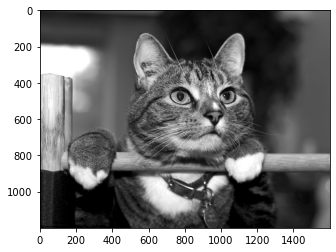

In [73]:
plt.figure()
plt.imshow(image)
plt.show()

Now, we calculate the number of elements (bytes in this case) in our image.

In [74]:
data_buffer_size=image.shape[0]*image.shape[1]*image.shape[2]
print(data_buffer_size)

5760000


Then, we create an instance of Shared Array object (who contains a lock property and get_lock() element). We need to know the C data type (in order to know how many bytes uses the single data type and the length of the linear array)

In [75]:
shared_space= Array(ctypes.c_byte,data_buffer_size)

Because the use of a Matrix as a linear vector could be hard to understand and visualize, we could create a new variable of type NumPy vector and set to use the prelocated memory space.<br/>

Once we create that NumPy variable, we can reshape this variable to see like a 3 dimensional vector (tensor)

In [76]:
shared_data=my.tonumpyarray(shared_space)
result_matrix=shared_data.reshape(image.shape)

In [77]:
image.shape

(1200, 1600, 3)

In [78]:
result_matrix.shape

(1200, 1600, 3)

In [79]:
my_filter=np.ones((3,3),dtype=np.uint8)

In [80]:
filter_o = my.filter(image,my_filter)

This first example, we will copy in the shared space the original image, in parallel.<br/>

In this case, we do not have memory hazzards (in theory), because we never tries to access at the same row from different parallel processes.

In [81]:
rows=range(image.shape[0])
with mp.Pool(processes=NUMCORES,initializer=my.init_sharedarray,initargs=[shared_space,image.shape]) as p:
    p.map(filter_o.parallel_shared_imagecopy,rows)

The difference with the previous session code, is: we are not returning the filtered row data, and construct the final image. We are writing in a shared memory 

In [82]:
print(type(shared_data))

<class 'numpy.ndarray'>


In [83]:
print(result_matrix.shape)

(1200, 1600, 3)


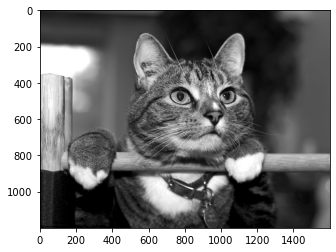

In [84]:
plt.figure()
plt.imshow(result_matrix)

## Shared memory assignment

In the myfunctions module, we have the function: edge_filter, which get a filter, and apply it to the image, writing the filtered row in to the shared r/w memory.
Check the code implementation, and modify it. Analyze the code. Which error we have? Check the order of instructions. It is efficent?

Implements several edge filters, like the described in https://en.wikipedia.org/wiki/Edge_detection

**AFTER ANALYZING THE CODE:**

**1.Which error we have?**

The main error in the code lies in how the filter indices (r_f and c_f) are calculated. These indices are supposed to represent the row and column inside the 3×3 filter mask, taking values from 0 to 2 depending on the horizontal (h) and vertical (v) shifts. Instead of resetting for each neighbor pixel, the code initializes them at 1 and then updates them cumulatively with += h and += v.

As a result, the indices drift across iterations and no longer match the correct filter positions. For example, when h = -1, c_f becomes 0 as expected, but when h = 0 it incorrectly remains 0 instead of 1, and when h = 1 it becomes 1 instead of 2. The same issue occurs for r_f. This causes pixels to be multiplied by the wrong filter coefficients, making the convolution results incorrect.

The correct mapping would be: r_f = v + 1  /  c_f = h + 1


**2.Check the order of instructions. It is efficent?**

No, the order of instructions in the filter code is not efficient.

The main inefficiency comes from how the convolution loop is structured. The variables prow, srow, and nrow are computed at the beginning of the method but are never actually used, that means we’re slicing parts of the image and storing them for nothing. As mentioned above, inside the nested loops, r_f and c_f are updated incorrectly and repeatedly, instead of being computed directly as r_f = v + 1 and c_f = h + 1. This causes unnecessary operations and makes the logic harder to follow.

The code casts to uint8 twice (once per pixel and again for the whole row), making the first conversion redundant and wasting CPU time.

In [60]:
#This is the this is the diferential second order differential edge filter
my_filter=np.zeros((3,3))
my_filter[0,0]=-0.25
my_filter[0,2]=0.25
my_filter[2,0]=0.25
my_filter[2,2]=-0.25

# The edge filters we have decided to try are:

#1: Scharr Operator
sc_filter= np.array([[-3, 0, 3],
                [-10, 0, 10],
                [-3, 0, 3]])

#2: Prewit Operator
pr_filter = np.array([[-1, 0, 1], 
                  [-1, 0, 1], 
                  [-1, 0, 1]])

#3: Sobel Operator
so_filter = np.array([[-1, 0, 1],
                    [-2, 0, 2],
                    [-1, 0, 1]])

In [ ]:
NUMCORES = 4

**1.FILTERED IMAGE AFTER CORRECTING THE EDGE_FILTER:**

In [61]:
filter_o = my.filter(image,my_filter)
rows=range(image.shape[0])
with mp.Pool(processes=NUMCORES,initializer=my.init_sharedarray,initargs=[shared_space,image.shape]) as p:
    p.map(filter_o.edge_filter,rows)

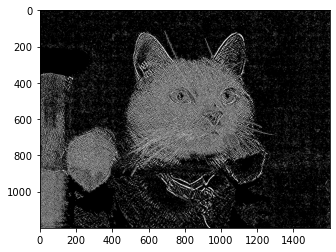

In [62]:
plt.figure()
plt.imshow(result_matrix)

Highlights fine textures and diagonal edges, making details like whiskers and fur stand out, while leaving flat regions dark.



**2.FILTERED IMAGE USING SCHARR FILTER:**

In [88]:
filter_o = my.filter(image,sc_filter)
rows=range(image.shape[0])
with mp.Pool(processes=NUMCORES,initializer=my.init_sharedarray,initargs=[shared_space,image.shape]) as p:
    p.map(filter_o.edge_filter,rows)

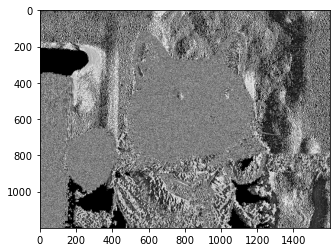

In [89]:
plt.figure()
plt.imshow(result_matrix)

**3.FILTERED IMAGE USING PREWIT FILTER:**

In [90]:
filter_o = my.filter(image,pr_filter)
rows=range(image.shape[0])
with mp.Pool(processes=NUMCORES,initializer=my.init_sharedarray,initargs=[shared_space,image.shape]) as p:
    p.map(filter_o.edge_filter,rows)

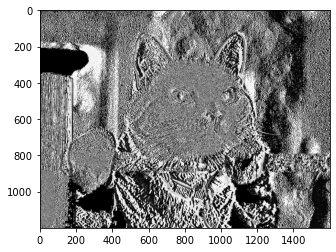

In [91]:
plt.figure()
plt.imshow(result_matrix)

**4.FILTERED IMAGE USING SOBEL FILTER:**

In [86]:
filter_o = my.filter(image,so_filter)
rows=range(image.shape[0])
with mp.Pool(processes=NUMCORES,initializer=my.init_sharedarray,initargs=[shared_space,image.shape]) as p:
    p.map(filter_o.edge_filter,rows)

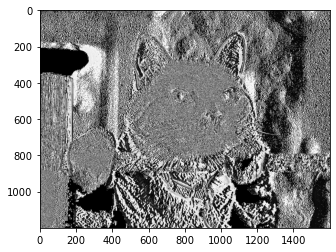

In [87]:
plt.figure()
plt.imshow(result_matrix)

**CONCLUSION**

In this assignment, we focused on implementing and analyzing a parallelized image filtering algorithm using shared memory to efficiently handle large images. The main objective was to apply 3×3 edge detection filters efficiently while distributing the workload across multiple processes.

By using shared memory, we ensured that processes could write results into a common matrix without unnecessary data duplication, making the implementation both memory-efficient and scalable.

During the process, we identified and corrected errors in the original code, particularly in the way filter indices were computed. Fixing these issues allowed the convolution to produce accurate results and improved the clarity of the implementation. We also paid attention to border handling by clamping indices to valid ranges, ensuring that edge pixels were processed correctly.

Finally, we tested different classical edge detection filters (such as Scharr, Prewitt and Sobel) to validate the correctness of our implementation. 

Overall, the assignment provided valuable practice in working with shared memory, process synchronization, and parallel execution, while also reinforcing how filtering operations can be efficiently scaled to large images.

**Assignment done by Javier Alzuaz and Enrique Velázquez**